# Exploratory Data Analysis

In [2]:
import pandas as pd

In [3]:
path = '/home/erazer/Downloads/addepto/house.csv'
table_csv = pd.read_csv(path)
table = table_csv.copy()
table.isna().sum()
# preliminary look for nans, shows that the dataset has no nans

id               0
date             0
price            0
price_bin        0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Fortunately, the dataset has no missing values, which require careful analysis. in a very big short - if there are many missing values (>10%), it is rather safe to drop such a column altogether (unless it can be inferred that there is some reason behind NaNs - then it might be useful to group them as "MISSING" and treat them as a separate group for categorical variables). For continuous data the might be replaced with mean / median / mode and additional columns True / False could be added next to the place where they were placed to preserve the information that there were NaNs. 

In [4]:
table.dtypes

id                 int64
date              object
price            float64
price_bin          int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Dataset looks rather encouraging - not too many categorical features. I will proceed to feature generation from date time feature (I will look for the following - year, number of day of week, number of month, and boolean whether it is a holiday or not). However I have a feeling that these variables, rather important in predicting the sale of a retail items, might turn out useless in house prices predictions.

The task asks to model a price (regression and classification problem) basing on 22 variables. In such exercises it is important to deeply understand the data data scientist has and only then to perform the modelling task. As a way of understanding data it is worth plotting distributions of data, understanding whether there are many outliers or not, if so it might be useful to apply transformatiosn to the data. In terms of data types there are 3 main groups - categorical variables, ordinal variables and continuous variables. Categorical variables offer many ways to encode them (starting with algrithms that do it automatically like Cat Boost), for example one hot encoding (with few unique values) and target encoding with many unique values. The reason for target encoding is to avoid exploding dimensionality of the dataset. In this case the only categorical value there is, is a datetime, which will be "exploded" into 4 variables and later deleted. Other type of variables - visible as 'int64' type show a subjective grade of a property (it could be useful to take a very deep dive into information about this dataset and finding out what exactly are the conditions on assigning 'grade' variable). The last type of variables are continuous variables, here represented by price. In a table above floors, are described as a float variable, however it totally does not need to be so, it is rather on ordinal variable. In the following cells I will proceed doing an exploratory data analysis and trying to understand the relationships between the data and if needed eliminating outliers or rescaling the whole distribution if the kurtosis is be too high. After some visual exploration of the data, I will proceed to eliminate variables that are much correlated (above some subjectively chosen threshold) with each other, as they do not add information and tend to result in model overfitting. As the last part I will evalaute ensembles - bagging, boosting and stacking on the problems together with some optimized parameter seach for optimal hyperparameters and then finally will shortly discuss theresults and possible venues for improvement.

In [5]:
# defininig a function for date feature exploding
def date_feature(date):
    """number of month, day of week, vacation, assuming US vacations"""
    from dateutil import parser
    import holidays
    us_holidays = holidays.UnitedStates()
    datetime_obj = parser.parse(date)
    weekday = datetime_obj.weekday()  # 0 is monday
    month = datetime_obj.month
    year = datetime_obj.year
    is_holiday = datetime_obj in us_holidays or weekday==6 or weekday==5  # includes weekends as holidays
    return weekday, month, year, int(is_holiday)

In [6]:
table['year'] = [date_feature(table.date[i])[2] for i in range(len(table))]
table['day_number'] = [date_feature(table.date[i])[0] for i in range(len(table))]
table['month_number'] = [date_feature(table.date[i])[1] for i in range(len(table))]
table['is_holiday'] = [date_feature(table.date[i])[3] for i in range(len(table))]

table = table.drop(columns=['date'])

Taking a dive into two other datetime - like features I can see that in many cases there is a missing date for renovating year, which needs treatment. It probably indicates that the house has never been renovated, and logically I would consider the date at which it was built to indicate the condition at which the house is at the current moment.

In [7]:
(table.yr_renovated==0).sum()

20699

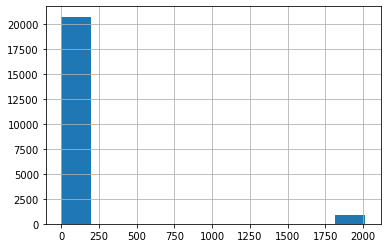

In [8]:
table.yr_renovated.hist()

I will substitute these values with the year of construction

In [9]:
table.yr_renovated.replace(0,table.yr_built,inplace=True)

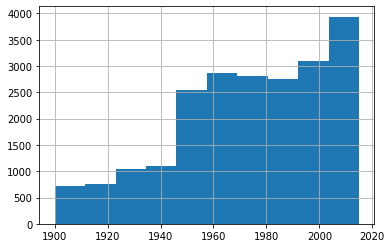

In [10]:
table.yr_renovated.hist()

It is rather important how long ago the house was renovated, not in what year it happened, therefore I will create an additional feature, year now - year renovated. The same logic applies to the year of building.

In [11]:
table['time_since_renovation'] = table['year'] - table.yr_renovated

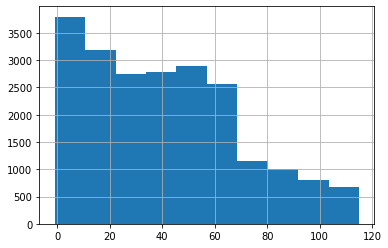

In [12]:
table['time_since_renovation'].hist()

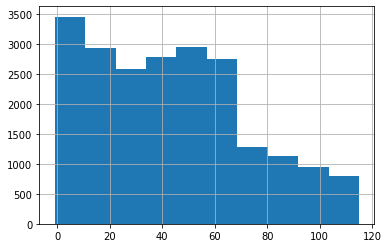

In [13]:
table['time_since_built'] = table['year'] - table.yr_built
table['time_since_built'].hist()

In [14]:
table[['time_since_built', 'time_since_renovation']].corr()

,time_since_built,time_since_renovation
time_since_built,1.000000,0.909948
time_since_renovation,0.909948,1.000000


The value is too correlated to input into a model, so I will just keep the time since last renovation

In [15]:
table = table.drop(columns=['time_since_built', 'yr_renovated', 'yr_built'])

In [16]:
table.nunique()

id                       21436
price                     3625
price_bin                    2
bedrooms                    13
bathrooms                   30
sqft_living               1038
sqft_lot                  9782
floors                       6
waterfront                   2
view                         5
condition                    5
grade                       12
sqft_above                 946
sqft_basement              306
zipcode                     70
lat                       5034
long                       752
sqft_living15              777
sqft_lot15                8689
year                         2
day_number                   7
month_number                12
is_holiday                   2
time_since_renovation      117
dtype: int64

In [17]:
len(table)

21613

According to the descrption ID should be unique, however there are fewer ids than number of observations, suggesting duplicates which might make fitting the right model more challenging than it needs to be. I will drop the duplicates.

In [18]:
table.id.duplicated().sum()

177

In [19]:
table = table.drop_duplicates(subset=['id'])
table = table.drop(columns=['id'])

I will separate the target vartiables, however will keep removing them from the original dataframe till the last moment, as I they will be needed later on in graphical exploration.

In [20]:
target_regression = table.price.copy()
target_classification = table.price_bin.copy()
table = table.drop(columns=['price_bin'])

In [21]:
print("Skewness: %f" % target_regression.skew())
print("Kurtosis: %f" % target_regression.kurt())

Skewness: 4.026120
Kurtosis: 34.555805


High Kurtosis means that data might have many outliers, that make predictive modelling more challenging. Positive skewness - data is skewed to the right. One way of dealing with this is applying log-transform of the data, and this is a method I choose. If using a model in "real-life" it would be extremely important to remember that the model just predicts log likelihood of the price, not the price! To get the price take the exp(result) - 1.

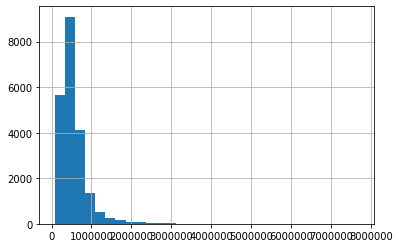

In [22]:
target_regression.hist(bins=30)

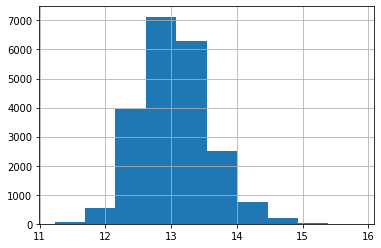

In [23]:
import numpy as np
def log_transform(column):
    return pd.Series(np.log(1 + column))  # 1 is just a good practice, not changing anything here, 
# but in some cases might prevent from making a silly mistake and loosing time figuring it out

log_transform(target_regression).hist()

In [24]:
log_transform(target_regression).kurt(), log_transform(target_regression).skew()

(0.6958122792605019, 0.4289801385506959)

In [25]:
target_regression_log_scaled = log_transform(target_regression)

In the same way I will inspect other variables and will rescale the ones that have a high kurtosis value. If the model were to applied on the real data it would be vital to do the same data transformation.

In [26]:
table.kurt()

price                     34.555805
bedrooms                  49.638224
bathrooms                  1.291488
sqft_living                5.249076
sqft_lot                 284.083543
floors                    -0.490774
waterfront               126.546660
view                      10.830498
condition                  0.517510
grade                      1.190269
sqft_above                 3.395082
sqft_basement              2.711988
zipcode                   -0.849689
lat                       -0.673600
long                       1.045532
sqft_living15              1.593321
sqft_lot15               150.324043
year                      -1.396433
day_number                -0.821099
month_number              -1.002045
is_holiday                27.715142
time_since_renovation     -0.523760
dtype: float64

In [27]:
sqft_lot_log  = log_transform(table.sqft_lot)
sqft_lot_log.kurt()

3.307092974655789

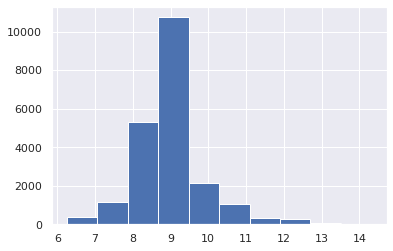

In [1080]:
sqft_lot_log.hist()

In [1081]:
table.sqft_lot = sqft_lot_log

Histograms looks much more promising, and so do kurtosis and skewness measures.

When dealing with geographical features it is important what areas do we model. 

In [1082]:
# Dataset coordinates indicate Seattle Area, I will proceed and extract
import folium
folium.Map(location = [table['lat'].mean(), table['long'].mean()], zoom_start = 10)


In [1083]:
from folium import plugins
houses_heatmap = folium.Map(location = [table['lat'].mean(), table['long'].mean()], zoom_start = 9)
houses_heatmap.add_children(plugins.HeatMap([[row["lat"], row["long"]] for name, row in table.iterrows()]))
# houses_heatmap.create_map("heatmap.html")
houses_heatmap

/home/erazer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


As a feature generated using geographical locations I choose mean and standard deviation per zipcode hoping that it can help the model learn useful information 
from the zipcode. It makes logical sense, some areas in town are more expensive than others.

In [1084]:

table['average_price_per_zipcode']=table.zipcode.map(table.groupby('zipcode').price.mean())
table['standard_deviation']=table.zipcode.map(table.groupby('zipcode').price.std())
table = table.drop(columns='zipcode')


For the beginning I will not use latitude and longitude to generate any new features (distance to some important landmarks in Seattle), hoping that model performance would be without it. They could be used by finding distances to important points (school, shops, architectural, airport etc).

In [1085]:
table = table.drop(columns=['lat', 'long'])

Inspecting correlations between variables

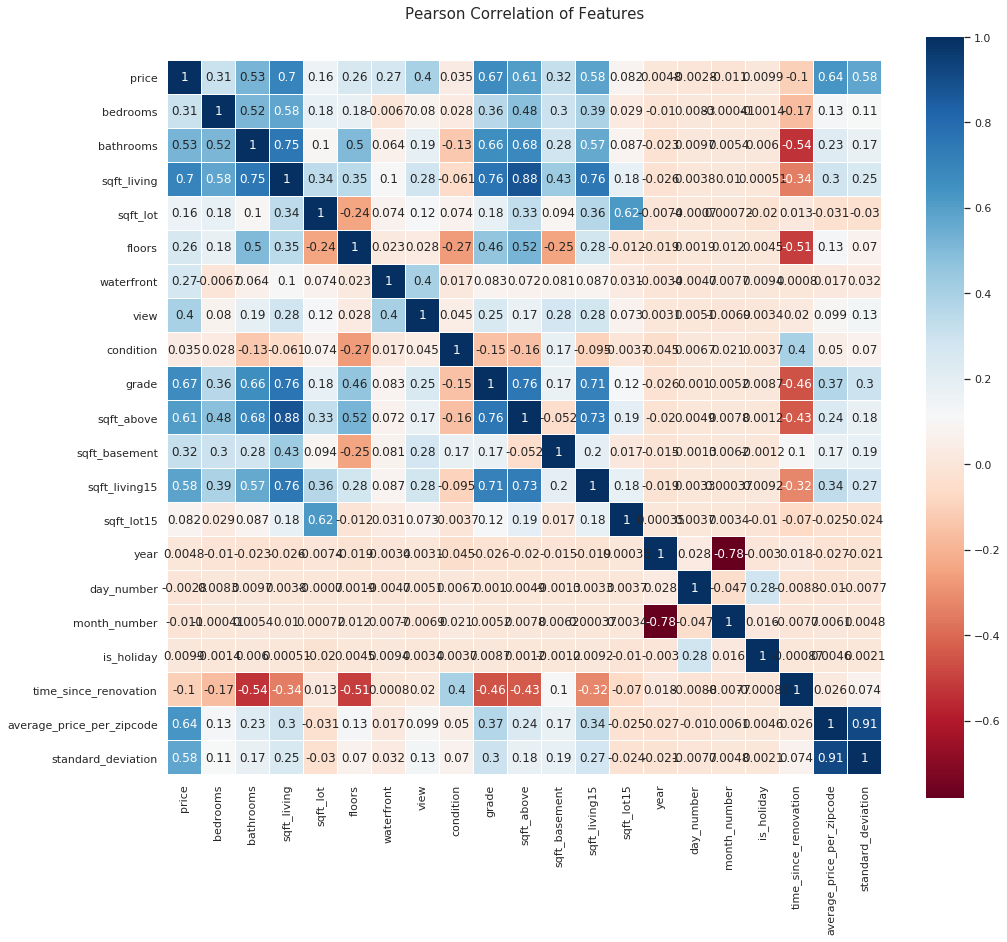

In [1086]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(table):
    """takes only numerical data"""
    colormap = plt.cm.RdBu
    plt.figure(figsize=(16, 14))

    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(table.astype(float).corr(), linewidths=0.1, vmax=1.0,
                square=True, cmap=colormap, linecolor='white', annot=True)
    
plot_correlation(table)

Observing the values in the correlation plot it is apparent, that column "standard_deviation" is not needed as it it extremely correlated with mean price per zip code, hence I will drop it.
Below I wrote a function to automatically get rid of columns that have correlation coefficient >= threshold, to ease "manual" labor.

In [1087]:
# defining the function the find over - correlated data

def correlation(dataset, threshold=0.7):
    # deals only with numeric data, float64 and int64, so here the values

    col_corr = set()  # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname]  # deleting the column from the dataset
    print(col_corr)
    return dataset

correlation(table)

{'sqft_living15', 'standard_deviation', 'sqft_above', 'sqft_living'}


,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,sqft_lot15,year,day_number,month_number,is_holiday,time_since_renovation,average_price_per_zipcode
0,221900.0,3,1.00,8.639588,1.0,0,0,3,7,0,5650,2014,0,10,1,59,310622.643411
1,538000.0,3,2.25,8.887791,2.0,0,0,3,7,400,7639,2014,1,12,0,23,469411.826303
2,180000.0,2,1.00,9.210440,1.0,0,0,3,6,0,8062,2015,2,2,0,82,461832.801418
3,604000.0,4,3.00,8.517393,1.0,0,0,5,7,910,5000,2014,1,12,0,49,551768.520913
4,510000.0,3,2.00,8.997271,1.0,0,0,3,8,0,7503,2015,2,2,0,28,686997.809195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,7.031741,3.0,0,0,3,8,0,1509,2014,2,5,0,5,584557.275000
21609,400000.0,4,2.50,8.668024,2.0,0,0,3,8,0,7200,2015,0,2,0,1,360927.839858
21610,402101.0,2,0.75,7.208600,2.0,0,0,3,7,0,2007,2014,0,6,0,5,595131.894118
21611,400000.0,3,2.50,7.778630,2.0,0,0,3,8,0,1287,2015,4,1,0,11,617204.948905


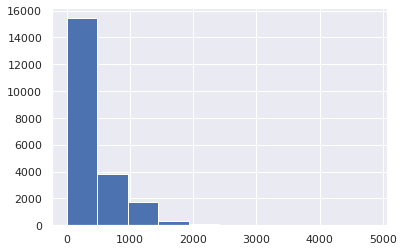

In [1088]:
table.sqft_basement.hist()

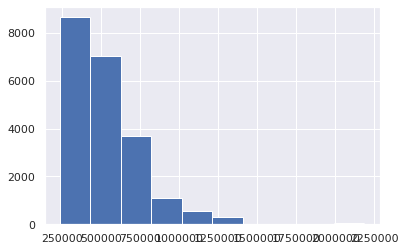

In [1089]:
table.average_price_per_zipcode.hist()

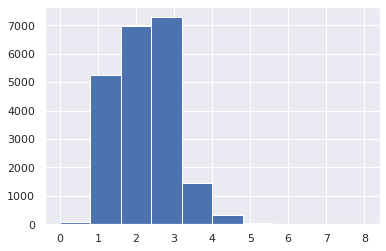

In [1090]:
table.bathrooms.hist()

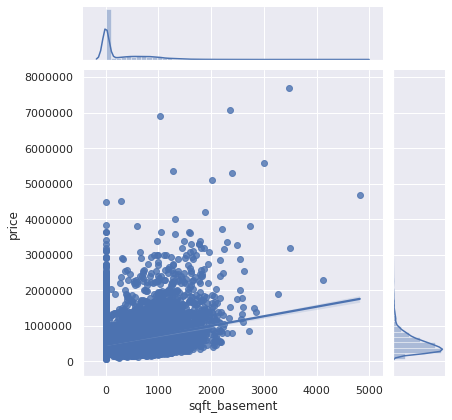

In [1091]:
sns.jointplot(x="sqft_basement", y=target_regression, data=table, kind="reg")

This feature looks promising, but it has many 0s, which make the slope of a regression line small.

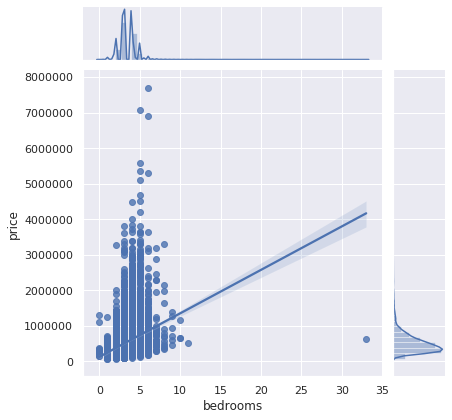

In [1092]:
sns.jointplot(x="bedrooms", y=target_regression, data=table, kind="reg")

This feature has an outlier that surely is a result of incorrect typing in the information about number of bedrooms - somebody has input 33, instead of 3 (inferred). I will hand-correct that feature 

In [1093]:
table.bedrooms[table.bedrooms==33] = 3

/home/erazer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


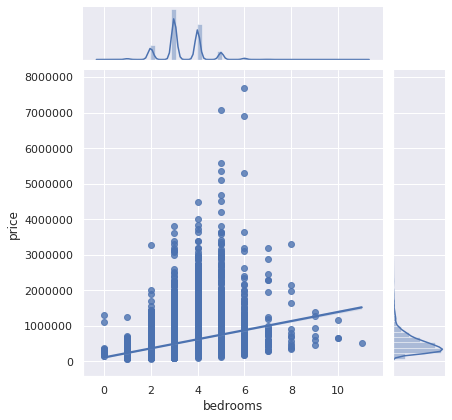

In [1094]:
sns.jointplot(x="bedrooms", y=target_regression, data=table, kind="reg")

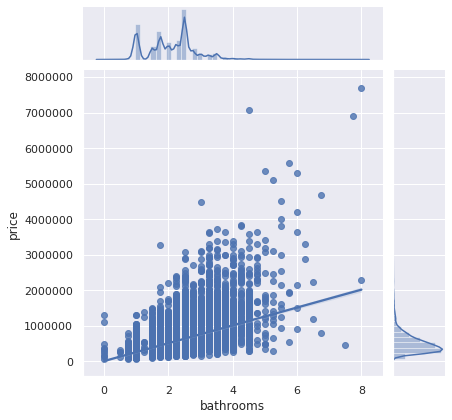

In [1095]:
sns.jointplot(x="bathrooms", y=target_regression, data=table, kind="reg")

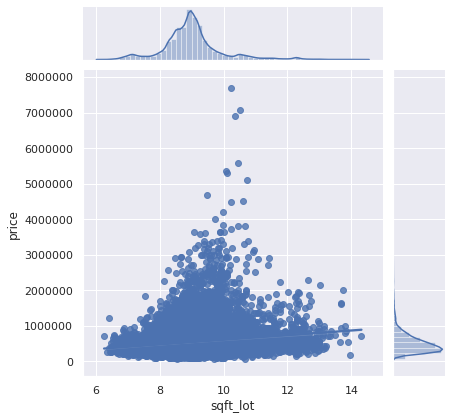

In [1096]:
sns.jointplot(x="sqft_lot", y=target_regression, data=table, kind="reg")

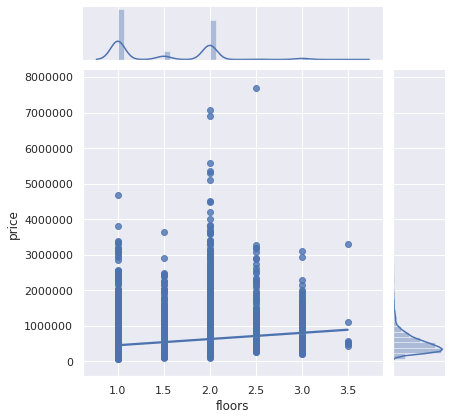

In [1097]:
sns.jointplot(x="floors", y=target_regression, data=table, kind="reg")

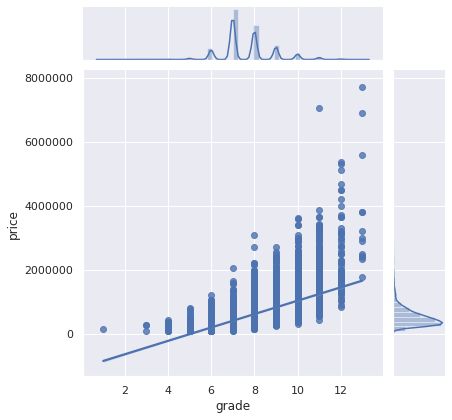

In [1098]:
sns.jointplot(x="grade", y=target_regression, data=table, kind="reg")

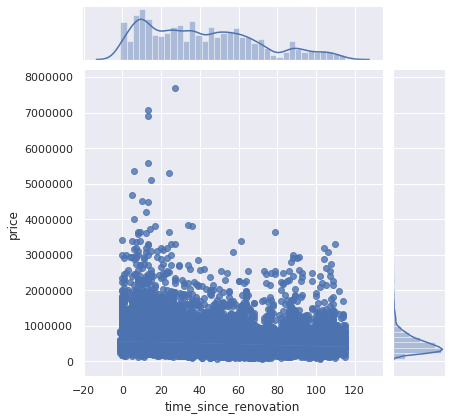

In [1099]:
sns.jointplot(x="time_since_renovation", y=target_regression, data=table, kind="reg")

A slightly decreasing trend

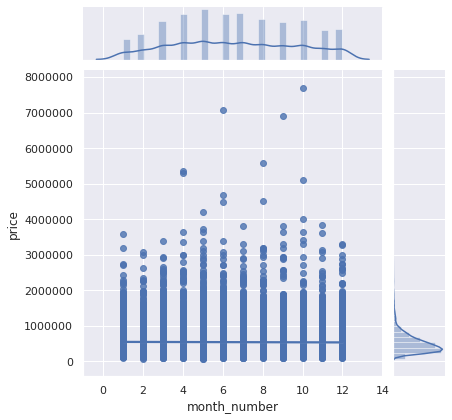

In [1100]:
sns.jointplot(x="month_number", y=target_regression, data=table, kind="reg")

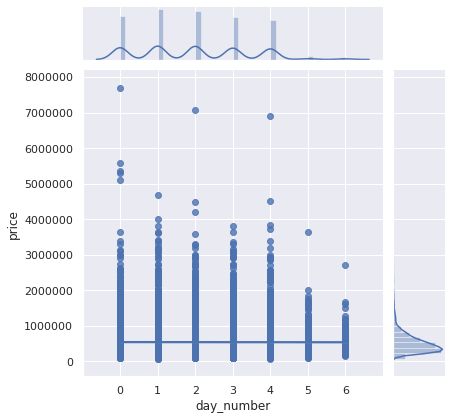

In [1101]:
sns.jointplot(x="day_number", y=target_regression, data=table, kind="reg")

Having plotted newly generated features (day number, month number) - ideas taken from predicting sales of a retail items, I can say that there is no relationship whatsoever between the price of the house and the number of day on which it was bought nor the month number etc. I will proceed and drop these columns.

In [1102]:
table = table.drop(columns=['month_number', 'day_number', 'is_holiday', 'year'])

In [1103]:
ordinal_data = table.select_dtypes('int64')

In [1104]:
ordinal_data.shape
ordinal_data.columns

Index(['bedrooms', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
       'sqft_lot15', 'time_since_renovation'],
      dtype='object')

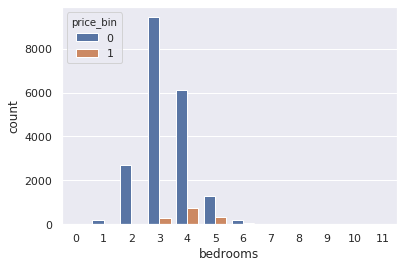

In [1106]:
sns.countplot(x=ordinal_data.bedrooms, hue=target_classification, data=ordinal_data)

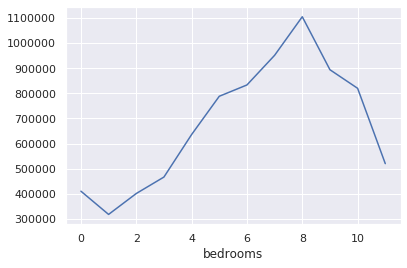

In [1107]:
table.groupby('bedrooms').price.mean().plot()

There seems to be a strong correlation - the more bedrooms - the more houses with price > 1M

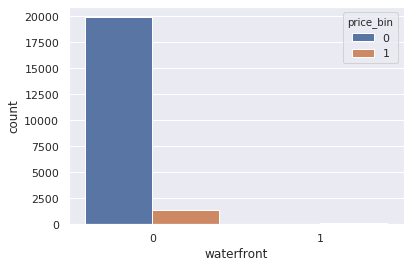

In [1108]:
sns.countplot(x=ordinal_data.waterfront, hue=target_classification, data=ordinal_data)

In [1109]:
table.groupby('waterfront').price.mean()

waterfront
0    5.320273e+05
1    1.662524e+06
Name: price, dtype: float64

The above shows that price is on average max higher with wetarfront than without, a very intuitive result

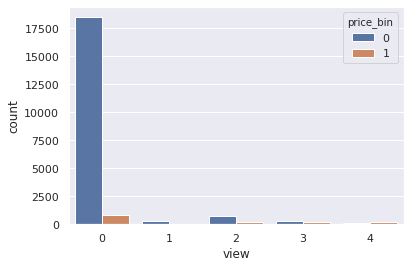

In [1110]:
sns.countplot(x=ordinal_data.view, hue=target_classification, data=ordinal_data)

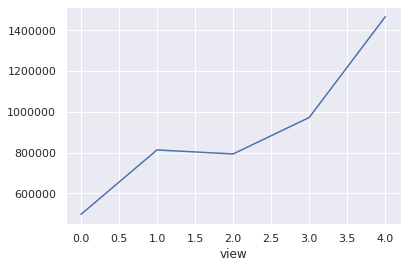

In [1111]:
table.groupby('view').price.mean().plot()

A very strong positive relationship between a view and a price.

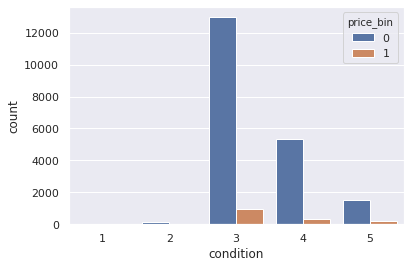

In [1112]:
sns.countplot(x=ordinal_data.condition, hue=target_classification, data=ordinal_data)

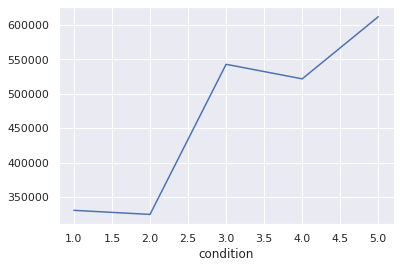

In [1113]:
table.groupby('condition').price.mean().plot()

The function is not monotonic, however seems to have a positive correlation between condition and a price.

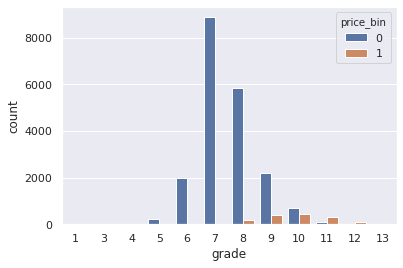

In [1114]:
sns.countplot(x=ordinal_data.grade, hue=target_classification, data=ordinal_data)

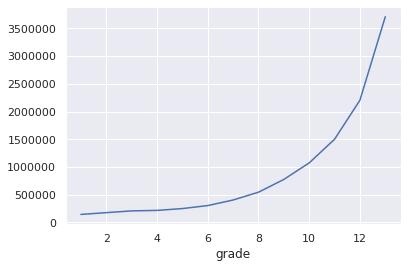

In [1115]:
table.groupby('grade').price.mean().plot()

A an exponential correlation between the grader and a price.

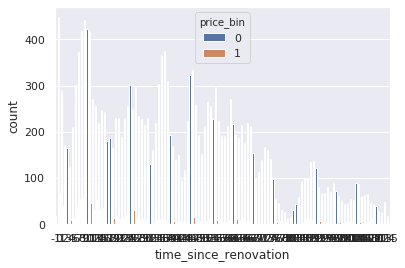

In [1116]:
sns.countplot(x=ordinal_data.time_since_renovation, hue=target_classification, data=ordinal_data)

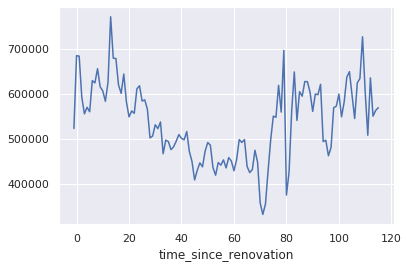

In [1117]:
table.groupby('time_since_renovation').price.mean().plot()

Rather noisy information.

# Regression Task

In [1118]:
# First try
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

table = table.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(table, target_regression_log_scaled, test_size=0.2, random_state=42)

def regression_task_first_try(X_train, X_test, y_train, y_test):
    clf = RandomForestRegressor()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    print(mean_squared_error(y_test, y_pred))
regression_task_first_try(X_train, X_test, y_train, y_test)

0.03691557583772424


The first try can usually be improved, this time I will use Random Search, later on I will present efficient parameter search using Bayesian Optimization with bayes - optim package.

In [1119]:
from sklearn.model_selection import RandomizedSearchCV
def optimize_random(X_train, X_test, y_train, y_test):
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf = RandomForestRegressor()

    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    return rf_random
rf_random = optimize_random(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


{'n_estimators': 178, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [1120]:
y_optim_pred = rf_random.predict(X_test)

In [1121]:
mean_squared_error(y_test, y_optim_pred)

0.036312800097358294

The error seems to be about the same. I did not standardize the data, as random forest does not require it. For future trials, however I will standardize it, as later algorithms might be influenced by data having different scales.

In [1122]:
def std_test_as_train(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    for col in X_train.columns:
        scaler = StandardScaler()
        scaler.fit(X_train[col].to_numpy().reshape(-1, 1))
        X_train[col] = scaler.transform(X_train[col].to_numpy().reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].to_numpy().reshape(-1, 1))  # fitting 
        # the standardization of train set to a test set
    return X_train, X_test
X_train, X_test = std_test_as_train(X_train, X_test)

/home/erazer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/erazer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/erazer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [1123]:
def stack(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LinearRegression
    from vecstack import stacking
    from sklearn import linear_model
    import xgboost as xgb
    from sklearn.metrics import roc_auc_score, classification_report, f1_score
    from sklearn.metrics import median_absolute_error
    from sklearn.ensemble import RandomForestRegressor

    models = [linear_model.SGDRegressor(max_iter=1000, tol=1e-3), RandomForestRegressor(), xgb.XGBRegressor(n_jobs=-1)]

    S_train, S_test = stacking(models, X_train, y_train, X_test, regression=True, verbose=2)

    model = xgb.XGBRegressor(seed=0, n_jobs=-1, learning_rate=0.1,n_estimators=100, max_depth=3)

    # Fit 2-nd level model
    model = model.fit(S_train, y_train)

    # Predict
    y_pred = model.predict(S_test)


    print(mean_squared_error(y_test, y_pred))

In [1124]:
stack(X_train, y_train, X_test, y_test)

/home/erazer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SGDRegressor]
    fold  0:  [0.18517293]
    fold  1:  [0.18457866]
    fold  2:  [0.18590817]
    fold  3:  [0.18871565]
    ----
    MEAN:     [0.18609385] + [0.00158526]
    FULL:     [0.18609385]

model  1:     [RandomForestRegressor]
    fold  0:  [0.14619310]
    fold  1:  [0.14151856]
    fold  2:  [0.14659460]
    fold  3:  [0.14749930]
    ----
    MEAN:     [0.14545139] + [0.00231938]
    FULL:     [0.14545139]

model  2:     [XGBRegressor]
    fold  0:  [0.14035799]
    fold  1:  [0.13905681]
    fold  2:  [0.14146091]
    fold  3:  [0.14393911]
    ----
    MEAN:     [0.14120371] + [0.00179395]
    FULL:     [0.14120371]

0.03392417897705959


The result using stacking did improve slightly.

In [1125]:
def fit_xgboost(X_train, X_test, y_train, y_test):
    import xgboost as xgb
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(mean_squared_error(y_test, y_pred))
    
fit_xgboost(X_train, X_test, y_train, y_test)

0.03533487724587716


For the regression task I have compared three types of ensemble models. Bagging - random forest classifier, gradient boosting - xgb regressor and stacking - training XGB regressor on the prediction of SGD Regressor, XGBoost Regressor and RandomForestRegressor. I tried to tune Random Forest, with slightly improved result.

# Classification task

In [1126]:
target_classification.value_counts() / len(target_classification)

0    0.93203
1    0.06797
Name: price_bin, dtype: float64

Dataset is unbalanced with 93.2% of data in house under 1M and the rest with price bucket >1M, hence I will use roc_auc_curve and f1_metric

In [1127]:
X_train, X_test, y_train, y_test = train_test_split(table, target_classification, test_size=0.2, random_state=42)

Off the shelf models

In [1128]:
def fit_xgboost(X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score, classification_report, f1_score
    import xgboost as xgb

    model = xgb.XGBClassifier(seed=0, n_jobs=-1, learning_rate=0.1,
                              n_estimators=10, max_depth=5)

    model = model.fit(X_train, y_train)


    # Predict
    y_pred = model.predict(X_test)
    print('f1:\t\n', f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return model

In [1129]:
fit_xgboost(X_train, X_test, y_train, y_test)

f1:	
 0.693069306930693
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4014
           1       0.76      0.64      0.69       274

    accuracy                           0.96      4288
   macro avg       0.87      0.81      0.84      4288
weighted avg       0.96      0.96      0.96      4288



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [1130]:
def fit_random_forest(X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score, classification_report, f1_score
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=300)

    model = model.fit(X_train, y_train)


    # Predict
    y_pred = model.predict(X_test)
    print('f1:\t\n', f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return model
fit_random_forest(X_train, X_test, y_train, y_test)

f1:	
 0.7148760330578513
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4014
           1       0.82      0.63      0.71       274

    accuracy                           0.97      4288
   macro avg       0.90      0.81      0.85      4288
weighted avg       0.97      0.97      0.97      4288



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Off-the-shelf Random forest performs better than off-the-shelf XGBoost, hence I will have a closer look and tune Random forest with bayes optim library. I will tune Random forest using bayes optim library to find best parameters for Random Forest better than using Randomized Search.

In [1131]:
def bayes_optim(X_train, X_test, y_train, y_test):

    from bayes_opt import BayesianOptimization
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score

    def bayesian_optimization(X_train, X_test, y_train, y_test, function, parameters):
        n_iterations = 10
        gp_params = {"alpha": 1e-4}
        BO = BayesianOptimization(function, parameters)
        BO.maximize(n_iter=n_iterations, **gp_params)

        return BO.max


    def rfc_optimization(cv_splits):
        def function(n_estimators, max_depth, min_samples_split):
            return cross_val_score(
                RandomForestClassifier(
                    n_estimators=int(max(n_estimators, 0)),
                    max_depth=int(max(max_depth, 1)),
                    min_samples_split=int(max(min_samples_split, 2)),
                    n_jobs=-1,
                    random_state=42),
                X=X_train,
                y=y_train,
                cv=cv_splits,
                scoring="f1_macro",
                n_jobs=-1).mean()

        parameters = {"n_estimators": (10, 1000),
                      "max_depth": (1, 150),
                      "min_samples_split": (2, 10)}

        return function, parameters

        # Train model
    def train(X_train, y_train, X_test, y_test, function, parameters):
        cv_splits = 4

        best_solution = bayesian_optimization(X_train, y_train, X_test, y_test, function, parameters)
        params = best_solution["params"]

        model = RandomForestClassifier(
            n_estimators=int(max(params["n_estimators"], 0)),
            max_depth=int(max(params["max_depth"], 1)),
            min_samples_split=int(max(params["min_samples_split"], 2)),
            n_jobs=-1,
            random_state=42,
            class_weight="balanced")

        model.fit(X_train, y_train)

        return model

    function, parameters = rfc_optimization(5)
    print(train(X_train, y_train, X_test, y_test, function, parameters))

In [1132]:
bayes_optim(X_train, X_test, y_train, y_test)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8643   |  52.13    |  2.228    |  441.5    |
|  2        |  0.8633   |  69.88    |  7.267    |  108.4    |
|  3        |  0.863    |  64.87    |  5.049    |  200.3    |
|  4        |  0.8624   |  119.3    |  9.169    |  621.6    |
|  5        |  0.8621   |  39.88    |  9.693    |  851.6    |
|  6        |  0.8632   |  147.3    |  6.631    |  999.0    |
|  7        |  0.8502   |  145.9    |  2.642    |  10.46    |
|  8        |  0.6111   |  2.079    |  9.483    |  997.6    |
|  9        |  0.4821   |  1.0      |  2.0      |  10.0     |
|  10       |  0.8616   |  52.6     |  3.548    |  444.5    |
|  11       |  0.8623   |  149.8    |  9.72     |  339.0    |
|  12       |  0.4821   |  1.498    |  3.242    |  658.5    |
|  13       |  0.8612   |  150.0    |  2.0      |  816.5    |
|  14       |  0.8623   |  150.0    |  2.0      |  500.4    |
|  15   

In [1133]:
def fit_random_forest(X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score, classification_report, f1_score
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=52, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=441,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

    model = model.fit(X_train, y_train)


    # Predict
    y_pred = model.predict(X_test)
    print('f1:\t\n', f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return model
fit_random_forest(X_train, X_test, y_train, y_test)

f1:	
 0.7240773286467487
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4014
           1       0.70      0.75      0.72       274

    accuracy                           0.96      4288
   macro avg       0.84      0.86      0.85      4288
weighted avg       0.96      0.96      0.96      4288



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=677,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Results show a slight improvement.
However they can likely still be improved using an upsampling method to make dataset more balanced. I will  upsample the dataset using imblearn library and SMOTE method.

In [1134]:
def upsample_data(X_train, y_train):

    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    return X_res, y_res

X_train, X_test, y_train, y_test = train_test_split(table, target_classification, test_size=0.2, random_state=42)
X_res, y_res = upsample_data(X_train, y_train)

In [1135]:
def fit_random_forest(X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score, classification_report, f1_score
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=52, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=441,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

    model = model.fit(X_train, y_train)


    # Predict
    y_pred = model.predict(X_test)
    print('f1:\t\n', f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return model
fit_random_forest(X_res, X_test, y_res, y_test)

f1:	
 0.6891025641025641
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4014
           1       0.61      0.78      0.69       274

    accuracy                           0.95      4288
   macro avg       0.80      0.88      0.83      4288
weighted avg       0.96      0.95      0.96      4288



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=677,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Upsampling the dataset using SMOTE resulted in a deteriorated f1 score, which is a recommendation against doing so if the model were to be used in a commercial application.

The above analysis started with exploratory data analysis, cleaning dataset (outliers) and scaling the dependent variable account for its high kurotsis. As a scaling function log(x+1) was used, resulting in a much improved variable distribution. 

I consider achieved results to be good, however if needed to improve them, I would focus in generating more features from the geographical data (mentioned before distances to some selected points). Also, I would have taken a closer look into the reason why some of the ids were duplicated - maybe the reason is easy to spot and therefore one could have slightly more data to model the price, which in turn would likely result in a slighty higher score. Another aspect could be having a still closer look into the distribution of the variables and still taking a closer look for possible outliers (I manually noticed one and corrected it, but maybe there were more, which I have not noticed), applying more / other transformations on the columns ( maybe even transform one column in a couple of different ways and stack them next to each other). Another aspect that comes to my mind is somehow passing in the information that the house was not renovated (values 0) - one way of doing it would be adding a dummy column with 1 - renovated and 0 - not renovated. In this way the information would have been preserved. I also think that classifiers could have been tuned more. For example, when stacking, I could have optimized each of the 1st level functions using bayes - optim library and then use functions with so selected hyperparameters as a first level predictor, likely could have got a slightly better rerult.